# Info 

Author: Xiaoqian Sun <br>
Created: 06/2024 <br>
Function: Apply Peeling algorithm read calcium traces to infer spikes. <br>

In [1]:
import os 
import time
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import Functions
import peelParams
import peelReconstruction 
import importlib;importlib.reload(Functions);importlib.reload(peelParams);importlib.reload(peelReconstruction)
from Functions import *
from peelReconstruction import peelReconstr
from peelParams import peelParams


import warnings
warnings.filterwarnings('ignore')

root_path = os.getcwd()
data_path = os.path.join(root_path, 'peel_ReadData')
result_path = data_path

/Users/xiaoqiansun/opt/anaconda3/lib/python3.8/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


# Read in data

NC436_day14_fup60.shape: (642, 300)


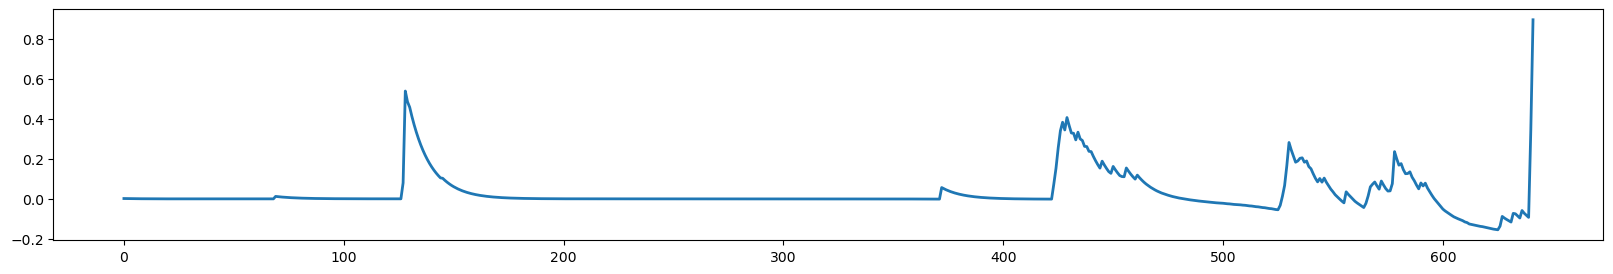

In [2]:
baseName = 'NC436_day14_fup60'
dff_df = pd.read_excel(os.path.join(data_path, 'NC436_WT_day14_dff_speeds.xlsx'), sheet_name='fup60').iloc[:, 1:]
print('NC436_day14_fup60.shape:', dff_df.shape)

# plot 1 neuron trace (same neuron)
plt.figure(figsize=(20,3));plt.plot(dff_df.iloc[:, 146], lw=2); plt.show()

# Peel

In [3]:
# prameters
kd = 170
conc = 1000 #nM
A1 = 0.5
tau1 = 0.6
fps=4630/6/120
schmitt=[0.3, -0.5, 0.3]
lowerT=0; upperT=0; 
verbose=False; ifPlot=False; noiseSD=1.18


# df to work on
numF, numN = dff_df.shape
x_dff = np.array(dff_df.index.tolist())/fps



# peel result storage initialize
peelObj_dic = {}
peel =  np.zeros((numN, numF))
dffRecon = np.zeros((numN, numF))
spkTimes = [[] for i in range(numN)]
spikeSummary = np.zeros((numN, numF)) 

In [4]:
startTime = time.time()

# peel on each neuron
for m in range(numN):
    
    # peelParam
    dff = dff_df.iloc[:, m]
    peelParam = peelParams(dff, kd=kd, conc=conc,  A1=A1, tau1=tau1, 
                           frameRate=fps, noiseSD=noiseSD,schmitt=schmitt)
    if m in [0,int(numN/2), numN-10]:
        print('Check if parameters are set up well:')
        print(' noiseSD=', peelParam.exp_p['noiseSD'], 'initial singleTransient', peelParam.data['singleTransient'][0:2] )
    

    # peelReconstr (use peelParam as input)
    peelObj = peelReconstr(dff=dff, xSampled=x_dff, spkTimes=None, 
                           lowerT=lowerT, upperT=upperT, 
                           verbose=verbose,ifPlot=ifPlot,params=peelParam)
    peelObj_dic['neuron'+str(m)] = peelObj
    
    # store result
    peel[m] = peelObj.params.data['peel'] # residual (dff after peeling off all spikes)
    dffRecon[m] = peelObj.dffRecon
    spkTimes[m] = peelObj.spkTimesRecon
    
    # from times to 0/1 array
    spkFrames = (peelObj.spkTimesRecon*fps).astype(int)
    spikeSummary[m][spkFrames] = 1
    
    
#     if len(peelObj.spkTimesRecon)!=0:print(len(peelObj.spkTimesRecon), 'spikes infered for neuron', m)


endTime = time.time()
print('Done. It took', round((endTime-startTime)/60,3), 'minutes')

dffRecon_DFF = pd.DataFrame(dffRecon).T
dff_peeled = pd.DataFrame(peel).T
spike_DF = pd.DataFrame(spikeSummary).T
print(dffRecon_DFF.shape, dff_peeled.shape, spike_DF.shape,)

Check if parameters are set up well:
 noiseSD= 1.18 initial singleTransient [0.1 0.1]
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spi

Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Optimizati

In [5]:
# save result
dffRecon_DFF.to_csv(os.path.join(result_path, baseName+'_dffReconstruct.csv'))
dff_peeled.to_csv(os.path.join(result_path, baseName+'_dffAfterPeel.csv'))
spike_DF.to_csv(os.path.join(result_path, baseName+'_SpikeInfered.csv'))

# Plot

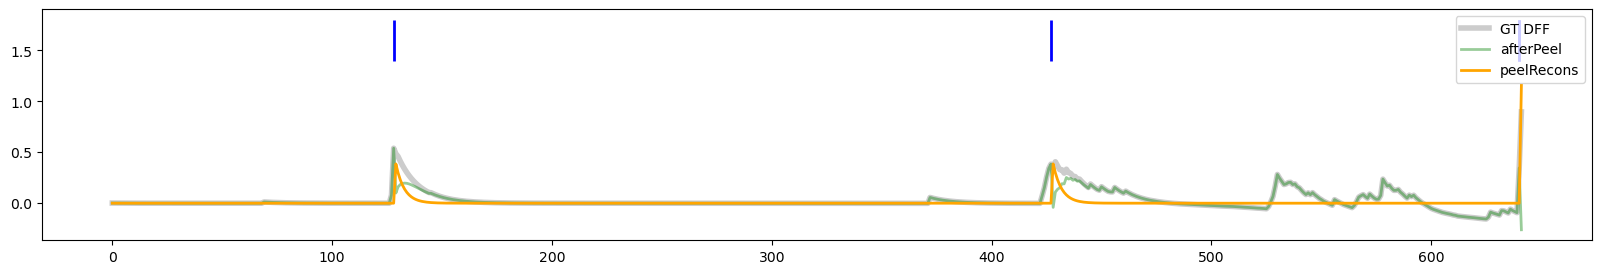

In [6]:
# plot to see

neuronIndex = 146
sMax = math.ceil(dff_df.iloc[:, neuronIndex].max())


plt.figure(figsize=(20,3),facecolor='w', edgecolor='k')

plt.plot(dff_df.iloc[:, neuronIndex], color='grey', lw=4, alpha=0.4, label='GT DFF')
plt.plot(dff_peeled.iloc[:, neuronIndex], color='green', lw=2, alpha=0.4, label='afterPeel')
plt.plot(dffRecon_DFF.iloc[:, neuronIndex], c='orange',lw=2, alpha=1, label='peelRecons')
plt.errorbar(spkTimes[neuronIndex]*fps, y=(sMax+0.6)*np.ones(len(spkTimes[neuronIndex])), yerr=0.2, fmt='none', c='blue', elinewidth=2)

plt.legend(loc=0); plt.show()

In [7]:
# plot more and save

subplotsNum = 30
fig,ax= plt.subplots(subplotsNum,1, figsize=(20,3*subplotsNum),facecolor='w', edgecolor='k')

for neuronIndex in range(subplotsNum):
    sMax = math.ceil(dff_df.iloc[:, neuronIndex].max())


    ax[neuronIndex].plot(dff_df.iloc[:, neuronIndex], color='grey', lw=4, alpha=0.4, label='GT DFF')

    ax[neuronIndex].plot(dff_peeled.iloc[:, neuronIndex], color='green', lw=2, alpha=0.4, label='afterPeel')

    ax[neuronIndex].plot(dffRecon_DFF.iloc[:, neuronIndex], c='orange',lw=2, alpha=1, label='peelRecons')

    spkFrames = spkTimes[neuronIndex]*fps; peelY=sMax+0.6
    ax[neuronIndex].errorbar(spkFrames, y=peelY*np.ones(len(spkFrames)), yerr=0.2, fmt='none', c='blue', elinewidth=2)
    ax[neuronIndex].legend(loc=0)

        
plt.tight_layout(); plt.savefig(os.path.join(result_path, baseName+'peelingResults')); plt.close()

# Memory Taken

In [8]:
# list all of the objects I have defined and sort them by their memory footprint


import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]

# Get a sorted list of the objects and their sizes
mem = {
    key: value
    for key, value in sorted(
        [
            (x, sys.getsizeof(globals().get(x))/1e6)  # in mb
            for x in dir()
            if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
        ],
        key=lambda x: x[1],
        reverse=True,
    )
}
print('Total memory usage:', sum(mem.values()))

Total memory usage: 10.816763999999981
